In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pygrib
import cfgrib
import glob

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [2]:
class Data():
    def get_eps_data(experiments, inidate='2022-02-16'):
        """
        Function to load comlete data of simulations on surface level since
        xr has a bug that prevents using
        this as a simpler solution

        Input:
        ------
        experiments: list of strings, list of experiments to import,
                e.g. ['pi', 'curr', 'incr']

        Output:
        -------
        eps: list of xarrays, data and metadata of operational forecasts,
        each list entry is one experiment
        """

        directory = {'pi': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/',
                    'curr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/',
                    'incr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/'}

        eps = {}
        for experiment in experiments:
            exp_eps = []
            for c, cont in enumerate(['cf', 'pf']):
                for files in glob.glob(directory[experiment]
                                        + cont + '/*'
                                        + inidate + '*.nc'):
                    print(files)
                    data = xr.open_dataset(files)
                    exp_eps.append(Data.preproc_ds(data.get(['fg10', 'msl',
                                                                'u10', 'v10',
                                                                'u100', 'v100'])))

            eps[experiment] = xr.concat(exp_eps, dim='number').squeeze()

        return eps
    

    def preproc_ds(ds):
        """
        Main pre-processing function
        Writtten by Nick Leach.

        Input:
        ------

        Output:
        -------
        """

        # accumulated variables & scaling factors
        accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                            'ttr': 1,
                            'tsr': 1,
                            'str': 1,
                            'ssr': 1,
                            'e': 1}
        accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                    'ttr': 'W m$^{-2}$',
                                    'tsr': 'W m$^{-2}$',
                                    'str': 'W m$^{-2}$',
                                    'ssr': 'W m$^{-2}$',
                                    'e': 'm s$^{-1}$'}
        ds = ds.copy().squeeze()
        # set up aux data
        inidate = pd.to_datetime(ds.time[0].values)
        # expand dimensions to include
        if not 'hDate' in ds:
            ds = ds.expand_dims({'inidate': [inidate]}).copy()

        if not 'number' in ds:
            ds = ds.expand_dims({'number': [0]}).copy()

        # put time dimension at front
        ds = ds.transpose('time', ...)
        ds = ds.copy(deep=True)

        # convert accumulated variables into instantaneous
        for var, sf in accumulated_vars.items():
            if var in ds.keys():
                ds[var].loc[dict(time=ds.time[1:])] = Data.accum2rate(ds[var]) * sf
                # set first value to equal zero,
                # should be zero but isn't always
                ds[var].loc[dict(time=ds.time[0])] = 0
                ds[var].attrs['units'] = accumulated_var_newunits[var]
        return ds

In [46]:
experiments = ['pi','curr','incr']
initial_date = '2022-02-10'

da_pi = Data.get_eps_data(['pi'],inidate=initial_date)
da_curr = Data.get_eps_data(['curr'],inidate=initial_date)
da_incr = Data.get_eps_data(['incr'],inidate=initial_date)

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nr_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nr_2022-02-10.nc


In [47]:
wind_gusts_pi = da_pi['pi'].sel(time='2022-02-18').fg10
wind_gusts_curr = da_curr['curr'].sel(time='2022-02-18').fg10
wind_gusts_incr = da_incr['incr'].sel(time='2022-02-18').fg10

avg_wg_pi = wind_gusts_pi.quantile(0.95,dim=['latitude','longitude','time'])
avg_wg_curr = wind_gusts_curr.quantile(0.95,dim=['latitude','longitude','time'])
avg_wg_incr = wind_gusts_incr.quantile(0.95,dim=['latitude','longitude','time'])

In [9]:
pres_pi = da_pi['pi'].sel(time='2022-02-18 T00').msl

In [48]:
max_number = {}
max_number['pi'] = wind_gusts_pi.sortby(avg_wg_pi,ascending=False).number[:10]
max_number['curr'] = wind_gusts_pi.sortby(avg_wg_curr,ascending=False).number[:10]
max_number['incr'] = wind_gusts_pi.sortby(avg_wg_incr,ascending=False).number[:10]

In [28]:
wind_gusts_pi.sel(number=max_number['pi']).max(dim='time')

<xarray.DataArray 'fg10' (number: 10, latitude: 163, longitude: 289)>
array([[[ 9.94928  ,  9.2366905,  8.947826 , ..., 14.788624 ,
         14.517161 , 14.335317 ],
        [ 7.2938194,  7.7506065,  8.26569  , ..., 16.08068  ,
         15.744834 , 15.469891 ],
        [ 5.605009 ,  5.1369095,  5.8329678, ..., 16.637527 ,
         16.449593 , 16.145067 ],
        ...,
        [19.075472 , 19.113754 , 19.04937  , ..., 14.218727 ,
         14.188274 , 15.10533  ],
        [19.029358 , 19.107664 , 19.114624 , ..., 13.439141 ,
         14.038622 , 14.951327 ],
        [18.993685 , 19.105053 , 19.1851   , ..., 13.945524 ,
         14.2570095, 14.26223  ]],

       [[ 9.971033 ,  9.092258 ,  8.833847 , ..., 21.819681 ,
         21.9528   , 22.067652 ],
        [ 7.90374  ,  8.26656  ,  8.660704 , ..., 21.790098 ,
         21.92496  , 21.982384 ],
        [ 7.3399334,  6.2445107,  6.871834 , ..., 21.396826 ,
         21.522985 , 21.654367 ],
...
        [18.793568 , 18.691769 , 18.603893 , ...,  5.1273384,
          4.7358055,  5.5119095],
        [18.164505 , 18.560389 , 18.5804   , ...,  4.559181 ,
          5.75292  ,  6.7178307],
        [18.492523 , 18.796179 , 18.881447 , ...,  5.5023403,
          5.331806 ,  5.096016 ]],

       [[ 8.660704 ,  8.056002 ,  7.594864 , ..., 11.576317 ,
         11.807756 , 12.172316 ],
        [ 7.252926 ,  7.5835533,  8.100376 , ..., 12.007872 ,
         11.73032  , 11.38055  ],
        [ 4.8732777,  4.3782063,  5.4762383, ..., 11.706827 ,
         11.317905 , 11.03339  ],
        ...,
        [19.27385  , 18.720482 , 18.308937 , ...,  4.3903866,
          4.3747253,  5.0255394],
        [18.603024 , 18.267174 , 18.045307 , ...,  3.9553509,
          4.027567 ,  4.201582 ],
        [18.013983 , 17.906963 , 17.73295  , ...,  4.080641 ,
          4.1937504,  4.0910816]]], dtype=float32)
Coordinates:
  * number     (number) int64 50 10 41 5 32 44 28 30 13 35
    inidate    datetime64[ns] 2022-02-14
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0

In [ ]:
wd_pi = wind_gusts_pi.sel(number=max_number['pi']).max(dim='time').mean(dim='number')
wd_curr = wind_gusts_curr.sel(number=max_number['curr']).max(dim='time').mean(dim='number')
wd_incr = wind_gusts_curr.sel(number=max_number['incr']).max(dim='time').mean(dim='number')



pres_pi = da_pi['pi'].sel(time='2022-02-18 T12').msl.sel(number=max_number['pi'][0])
pres_curr = da_curr['curr'].sel(time='2022-02-18 T12').msl.sel(number=max_number['curr'][0])
pres_incr = da_incr['incr'].sel(time='2022-02-18 T12').msl.sel(number=max_number['incr'][0])

In [43]:
lon_min = -11
lon_max = 5
lat_min = 48
lat_max = 60

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-18','2022-02-18'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()
era5_MSL = era5_2022.msl.sel(time=slice('2022-02-18','2022-02-18'),latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)).resample(time = '1d').max().load()

lon_e =[-11.  , -10.75, -10.5 , -10.25, -10.  ,  -9.75,  -9.5 ,  -9.25,  -9.  ,
        -8.75,  -8.5 ,  -8.25,  -8.  ,  -7.75,  -7.5 ,  -7.25,  -7.  ,  -6.75,
        -6.5 ,  -6.25,  -6.  ,  -5.75,  -5.5 ,  -5.25,  -5.  ,  -4.75,  -4.5 ,
        -4.25,  -4.  ,  -3.75,  -3.5 ,  -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,
        -2.  ,  -1.75,  -1.5 ,  -1.25,  -1.  ,  -0.75,  -0.5 ,  -0.25,   0.  ,
         0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,   2.  ,   2.25,
         2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,   4.  ,   4.25,   4.5 ,
         4.75,   5.  ]
lat_e = [60.  , 59.75, 59.5 , 59.25, 59.  , 58.75, 58.5 , 58.25, 58.  , 57.75,
       57.5 , 57.25, 57.  , 56.75, 56.5 , 56.25, 56.  , 55.75, 55.5 , 55.25,
       55.  , 54.75, 54.5 , 54.25, 54.  , 53.75, 53.5 , 53.25, 53.  , 52.75,
       52.5 , 52.25, 52.  , 51.75, 51.5 , 51.25, 51.  , 50.75, 50.5 , 50.25,
       50.  , 49.75, 49.5 , 49.25, 49.  , 48.75, 48.5 , 48.25, 48.  ]

lat = da_pi['pi'].sel(time='2022-02-16 12').latitude.values
lon = da_pi['pi'].sel(time='2022-02-16 12').longitude.values

In [ ]:
#maximum_gusts_eps = {key:value.sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"]).mean(dim = "number") for (key,value) in eps.items()}

In [45]:
era5_GUST.head


<bound method DataArray.head of <xarray.DataArray 'fg10' (time: 1, latitude: 49, longitude: 65)>
array([[[15.595121, 16.07734 , 16.45516 , ..., 16.045025, 16.716154,
         15.77906 ],
        [14.004298, 14.492316, 14.884222, ..., 16.103024, 16.686325,
         15.934828],
        [12.900665, 13.212201, 13.580908, ..., 15.517238, 15.388811,
         14.247893],
        ...,
        [35.482895, 34.85568 , 34.33452 , ..., 23.168102, 22.955162,
         23.674347],
        [33.742104, 33.27977 , 33.465366, ..., 22.907936, 22.712397,
         21.269886],
        [32.17448 , 31.580406, 31.660776, ..., 21.642735, 21.146431,
         22.269949]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -11.0 -10.75 -10.5 -10.25 ... 4.5 4.75 5.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 48.5 48.25 48.0
  * time       (time) datetime64[ns] 2022-02-18
Attributes:
    units:      m s**-1
    long_name:  10 metre wind gust since previous post-processing>

/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


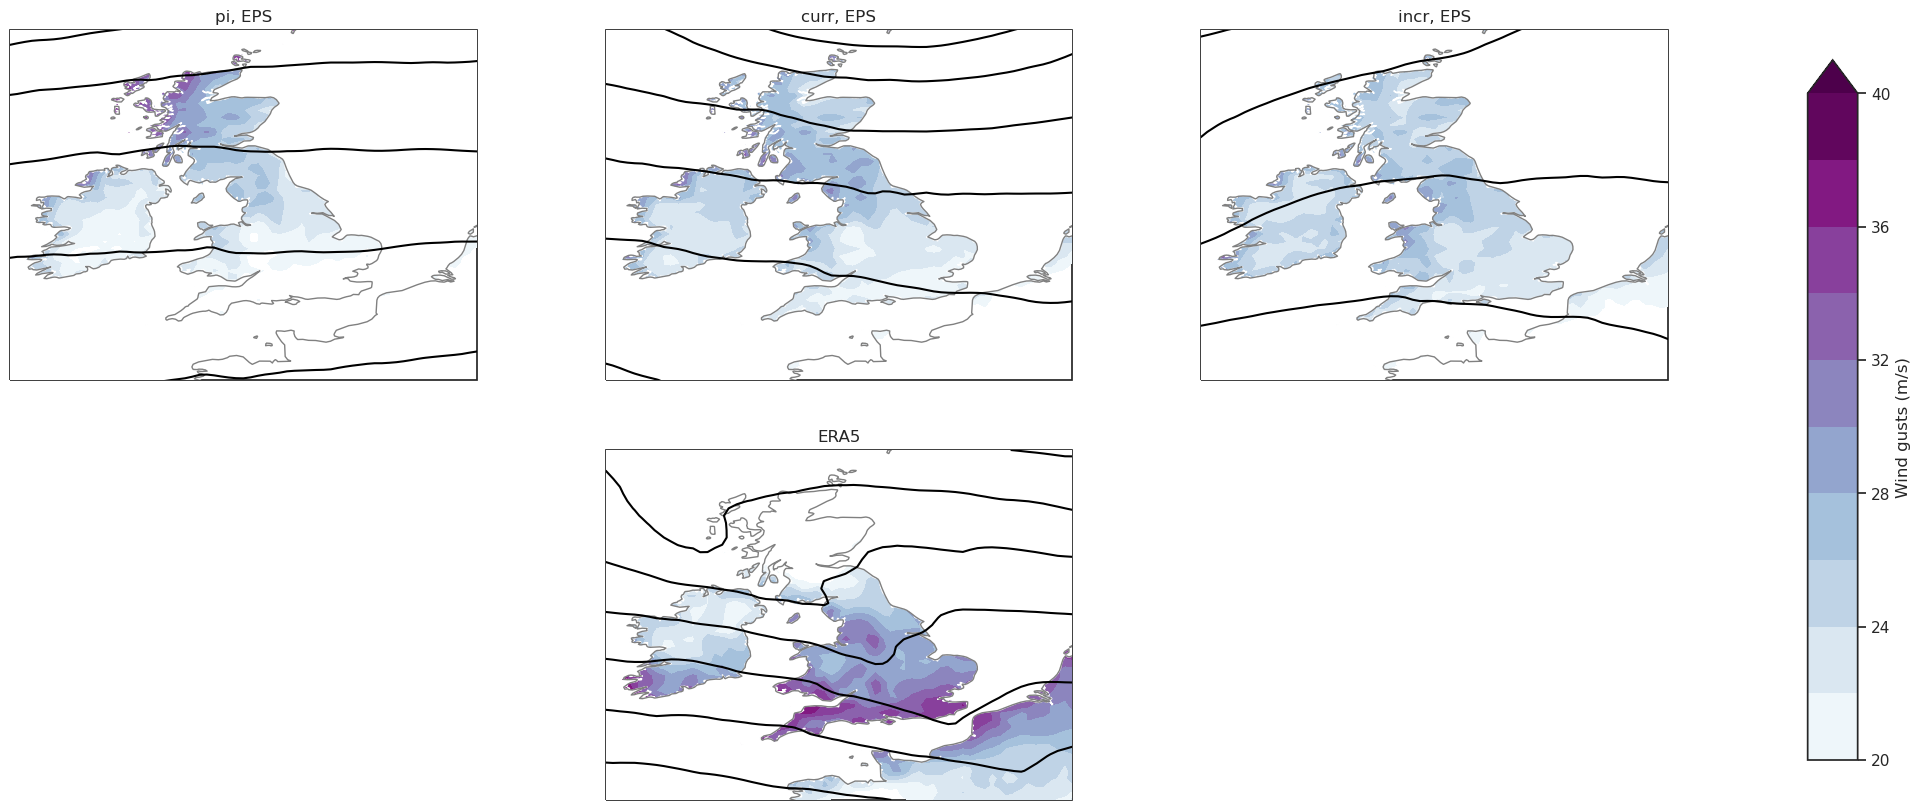

: 

In [50]:
uk = [-11, 5, 48, 60]
p_max = 1040
p_min = 960

fig = plt.figure(1, figsize=(25, 10))
clevs_fg10 = np.linspace(20, 40, 11)  # 17
clevs_p = np.linspace(p_min,p_max,17)
projection = ccrs.PlateCarree()

#subplot of pi
ax_pi = plt.subplot(2,3,1,projection = projection)
ax_pi.set_extent(uk, projection)
ax_pi.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax_pi.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10



cf = ax_pi.contourf(lon, lat, wd_pi, clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')
cs = ax_pi.contour(lon,lat, pres_pi, colors='black',
                    transform=projection, zorder = 16)
ax_pi.set_title('pi'+", EPS")

#subplot of curr
ax_curr = plt.subplot(2,3,2,projection = projection)
ax_curr.set_extent(uk, projection)
ax_curr.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax_curr.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

cf = ax_curr.contourf(lon, lat, wd_curr,clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')
cs = ax_curr.contour(lon,lat, pres_curr, colors='black',
                    transform=projection, zorder = 16)
ax_curr.set_title('curr'+", EPS")

#subplot of incr
ax_incr = plt.subplot(2,3,3,projection = projection)
ax_incr.set_extent(uk, projection)
ax_incr.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax_incr.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

cf = ax_incr.contourf(lon, lat, wd_incr, clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')
cs = ax_incr.contour(lon,lat, pres_incr, colors='black',
                    transform=projection, zorder = 16)
ax_incr.set_title('incr'+", EPS")

#subplot of era5
ax_era5 = plt.subplot(2,3,5,projection = projection)
ax_era5.set_extent(uk, projection)
ax_era5.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax_era5.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

cf = ax_era5.contourf(lon_e, lat_e, era5_GUST.sel(time='2022-02-18'), clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')
cs = ax_era5.contour(lon_e,lat_e, era5_MSL.sel(time='2022-02-18'), colors='black',
                    transform=projection, zorder = 16)
ax_era5.set_title('ERA5')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)', extend = 'max')

plt.savefig('figures/00_wind_gusts_eunice_inidate'+'2022-02-10'+'.png')
plt.savefig('figures/00_wind_gusts_eunice_inidate'+'2022-02-10'+'.pdf')

In [ ]:
xr.plot.contourf(lon_e, lat_e, era5_GUST.sel(time='2022-02-18'), clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')